# MCMC analysis of cosmological FRB constraints using the Pade Approximants

**Note**: This notebook tests main functions and code

## Run properties and loading modules

In [1]:
### If the MCMC functions need to be imported from a file, this should be OFF
## Depends on how the OS handles multiprossecing
RUN_IN_NOTEBOOK = True

SAVE_DATA = False
SAVE_FIG = False

In [2]:
import sys
sys.path.append('../Python_scripts')
sys.path.append('./interpolation')

### Import packages
from config import *
from support import *
from cosmo_support import *
from mcmc_support import *

In [3]:
# ## Plotting
# plt.rcParams['font.family'] ='Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [4]:
### MCMCM packages
# path='interpolation/068_C0median.npz'

if RUN_IN_NOTEBOOK:
    import emcee
    from multiprocessing import Pool
else:
    import mcmc_support_Svar
    mcmc_support_Svar.DATA_PATH = path
    mcmc_support_Svar.reload_with_path(path)
    from mcmc_support_Svar import *

## Generate data

In [5]:
## Number of random events
N_EVENTS = 20

## Draw random redshifts, based on given redshift
redshift_array = np.linspace(0.25, 2, 500)
z_centres = draw_redshift_distribution(redshift_array, H0=HUBBLE, Omega_m=OMEGA_MATTER, 
                                          N_draws=N_EVENTS)

In [6]:
DATA_PATH = './interpolation/095_C0mean.npz'
Sigmas, Errors, C0s, As, sigma_error_inter, C0_sigma_inter, A_sigma_inter = FRBs_load_and_create_interpolators(DATA_PATH)

In [7]:
# Theoretical DM, fiducial cosmo
DM_centres = dispersion_measure(z_centres, H0=HUBBLE, Om=OMEGA_MATTER, w=W_LAMBDA, alpha=f_ALPHA, f_IGM_0 = f_IGM)

In [8]:
## Simple Gaussian pdf - Scatter observations according to errors
DM_obs_centre_gauss = rng.normal(DM_centres, SIGMA_DM)

## Modelling the DM pdf -- Standard HOF
DM_obs_centre = np.zeros_like(z_centres)
s_DM_obs = np.zeros_like(z_centres)

for idx, z_val in enumerate(tqdm(z_centres)):
    DM_obs_centre[idx], s_DM_obs[idx], _ = \
        DM_diff_sampling(z=z_val, 
                        S=S_FRB, HOF=HOF,
                        sigma_error_inter=sigma_error_inter,
                        C0_sigma_inter=C0_sigma_inter,
                        A_sigma_inter=A_sigma_inter,
                        H0=HUBBLE, f_diff=f_IGM, f_diff_alpha=f_ALPHA,
                        Om=OMEGA_MATTER, w=W_LAMBDA, N_draws=1,
                        mode=None, #'standard'
                        Error_factor = 1
                        )

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.01it/s]


In [1]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(111)

ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='tab:blue')
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='g', label=f'N={N_EVENTS} (HOF)')


ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)

plt.show()

NameError: name 'plt' is not defined

In [10]:
initial_params = np.array([74, 0.25, -1.5])
pos = initial_params + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [22]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_frb, args=(z_centres, DM_obs_centre, s_DM_obs)
)
sampler.run_mcmc(pos, 10000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:47<00:00, 24.53it/s]


In [19]:
sampler_Pade = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_frb_Pade, args=(z_centres, DM_obs_centre, s_DM_obs)
)
sampler_Pade.run_mcmc(pos, 10000, progress=True);

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 284.01it/s]


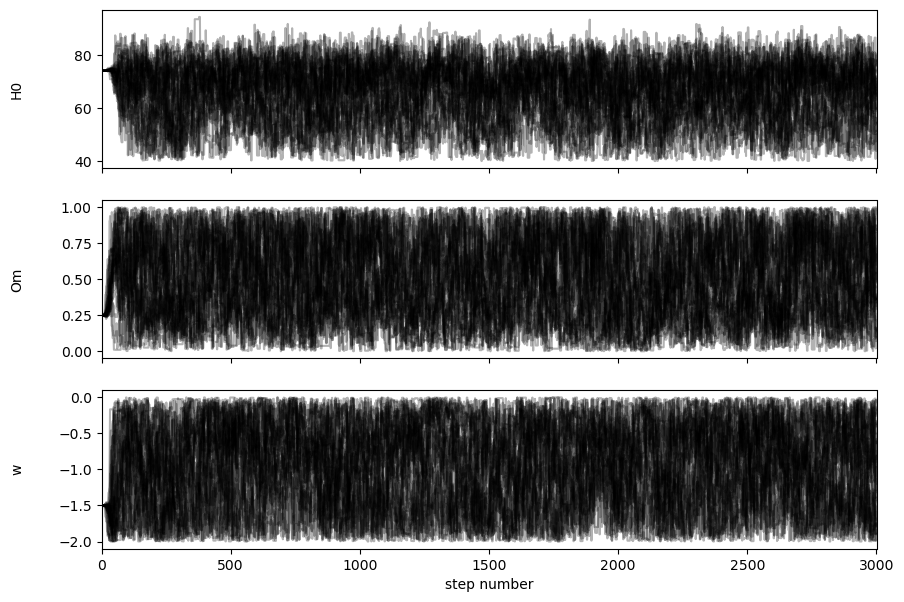

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0", "Om", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples_PD = sampler_Pade.get_chain(discard=100, thin=15, flat=True)

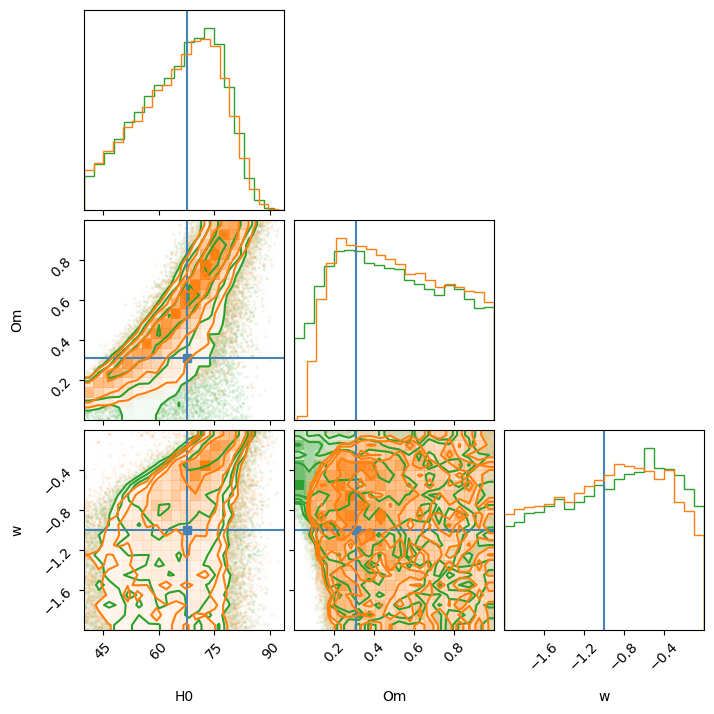

In [24]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[HUBBLE, OMEGA_MATTER, W_LAMBDA], color="C2"
)
corner.corner(
    flat_samples_PD, fig=fig, color="C1"
);

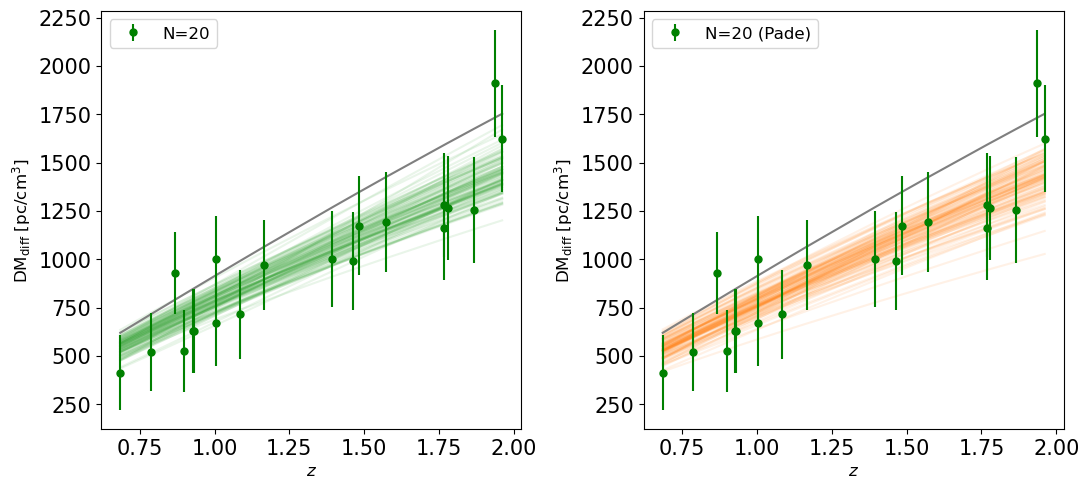

In [25]:
inds = np.random.randint(len(flat_samples), size=100)

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for ind in inds:
    sample = flat_samples[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax1.plot(np.sort(z_centres), DM_i, "C2", alpha=0.1)
ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='tab:grey')
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='g', label=f'N={N_EVENTS}')

ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)


for ind in inds:
    sample = flat_samples_PD[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax2.plot(np.sort(z_centres), DM_i, "C1", alpha=0.1)
ax2.plot(np.sort(z_centres), np.sort(DM_centres), c='tab:grey')
ax2.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='g', label=f'N={N_EVENTS} (Pade)')

ax2.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax2.set_xlabel(r'$z$', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

In [17]:
DM_pade_wCDM(0.5, 75, 0.3, -1)

496.85574585617366

In [18]:
dispersion_measure(z=0.5, H0=75, Om=0.3, w=-1, alpha=0, f_IGM_0 = 0.84)

np.float64(496.46233593250673)

# Preparation interpolation

In [9]:
if RUN_IN_NOTEBOOK:

    load_arrays=np.load(path)
    Sigmas=load_arrays['a']
    Errors=load_arrays['d']
    C0s=load_arrays['c']
    As=load_arrays['b']
    
    sigma_error_inter= interpolate.interp1d(Errors, Sigmas, kind=1,bounds_error=False, 
        # fill_value='extrapolate'
        )    
    
    ## Interpolation of C0 terms (see Macquart+ paper)
    C0_sigma_inter = interpolate.interp1d(Sigmas, C0s, kind=1,bounds_error=False, 
        # fill_value='extrapolate'
        )

    ## Interpolation of normalisation factor (so that pdf is normalised to 1)
    A_sigma_inter = interpolate.interp1d(Sigmas, As, kind=1,bounds_error=False, 
        # fill_value='extrapolate'
        )

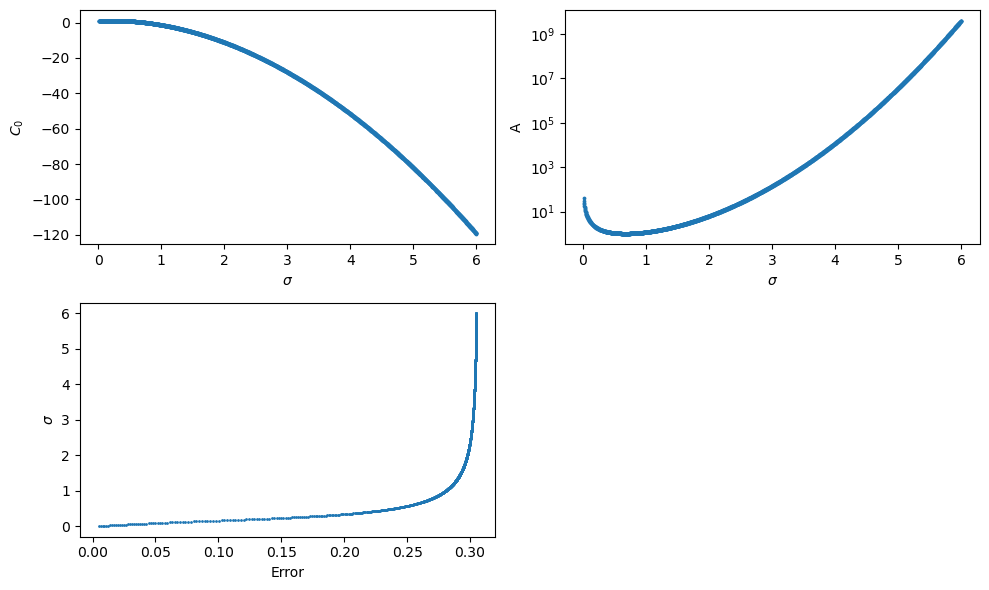

In [10]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)

ax1.scatter(Sigmas, C0s,  s=3)
ax1.set_ylabel(r'$C_0$')
ax1.set_xlabel(r'$\sigma$')

ax2.scatter(Sigmas, As,  s=3)
ax2.set_ylabel('A')
ax2.set_xlabel(r'$\sigma$')
ax2.set_yscale('log')

ax3.scatter(Errors, Sigmas,s=1)
ax3.set_ylabel(r'$\sigma$')
ax3.set_xlabel(r'Error')

plt.tight_layout()
plt.show()

# MCMC

**MCMC Run properties**

In [12]:
N_WALKERS = 2
HEATING = 0
N_STEPS = 40
LOAD_DATA = False

## Initial parameters for chains (adjust based on your model)
S_0 = 0.02
HOF_0 = 3.0
SIGMA_HOST_0 = 0.8
E_MU_0 = 150

In [ ]:
if LOAD_DATA:
    samples03=np.load('./posterior/mcmc_all_z03.npy')

else:
    # Main execution
    if __name__ == "__main__":

        # Define initial parameters: [F, HOf, sigma_host, e_mu]
        initial_params = np.array([S_0, HOF_0, SIGMA_HOST_0, E_MU_0])

        # Run MCMC
        sampler03 = run_mcmc(data_all_03, initial_params, nwalkers=N_WALKERS, heating=HEATING, nsteps=N_STEPS)

Running MCMC...
heating...


0it [00:00, ?it/s]

In [ ]:
def mcmc_analyze_results(sampler, burn_in=10, thin=15, target_prob=0.6827):
    """Analyze MCMC results (unchanged from original)"""
    flat_samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
    
    params_median = np.median(flat_samples, axis=0)
    params_lower = np.percentile(flat_samples, 50-target_prob*50, axis=0)
    params_upper = np.percentile(flat_samples, 50+target_prob*50, axis=0)
    
    params_errors = [(params_upper[i] - params_lower[i]) / 2 for i in range(len(params_median))]
    
    return flat_samples, params_median, params_errors

In [18]:
if not LOAD_DATA:
    # Analyze results
    samples03, params_median03, params_errors03 = mcmc_analyze_results(sampler03, burn_in=HEATING)

    # Print results
    param_names = ['S', 'HOf', 'sigma_host', 'e_mu']
    print("MCMC Results:")
    for i, name in enumerate(param_names):
        print(f"{name} = {params_median03[i]:.3f} ± {params_errors03[i]:.3f}")

    # Plot results
    # plot_results(samples, param_names)

    # Save samples to file for later analysis if needed
    if SAVE_DATA:
        np.save('./posterior/mcmc_all_z025.npy', samples03)

    print("\nMCMC analysis complete!")

else:
    print("Using loaded posteriors for analysis!")

MCMC Results:
S = 0.019 ± 0.006
HOf = 2.576 ± 0.240
sigma_host = 0.638 ± 0.197
e_mu = 137.936 ± 47.279

MCMC analysis complete!


**Analysing MCMC results**

In [ ]:
def mcmc_plot_results(samples, param_names, truths, savetitle=None, bins=30, target_prob=0.6827, font_size=15):
    """
    Plot the MCMC results.
    
    Args:
        samples: MCMC samples
        param_names: Names of the parameters
    """
    
    # Create corner plot
    
    fig = corner.corner(
        samples, 
        labels=param_names,
        truths=truths,
        truth_color='tab:orange',
        quantiles=[0.5-target_prob/2, 0.5, 0.5+target_prob/2], ### [0.16, 0.5, 0.84],
        q_ls=['--', ' ', '--'],
        show_titles=True,
        title_kwargs={"fontsize": font_size-2},
        label_kwargs={"fontsize": font_size},
        title_fmt='.3f',
        bins=bins,
        smooth=True,
        color='tab:blue'
    )

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=font_size)
    
    if savetitle is not None:
        plt.savefig(savetitle+"_corner_plot.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

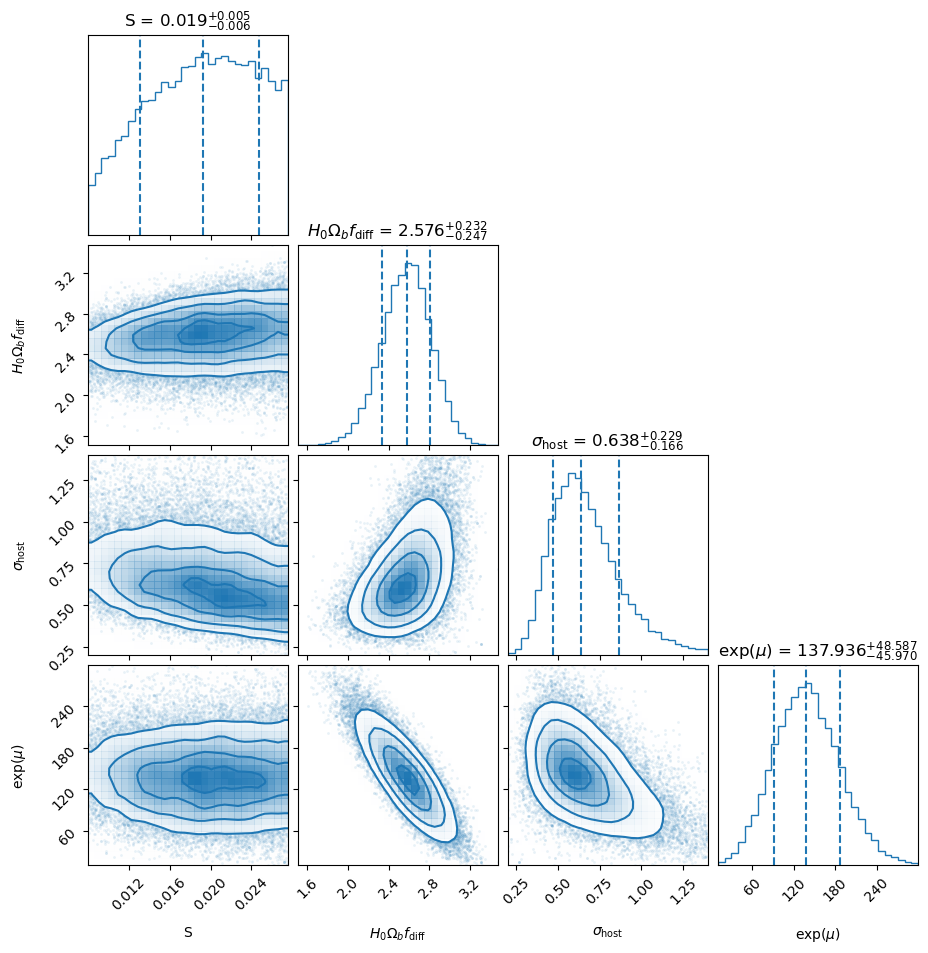

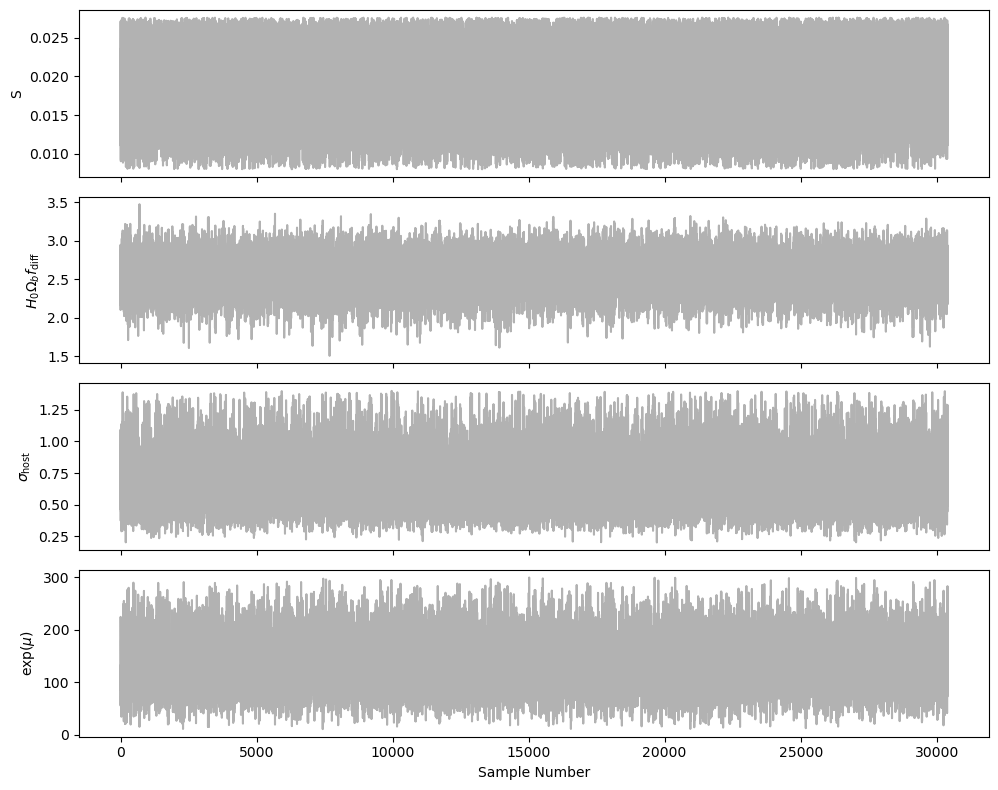

In [19]:
param_names_ext = [r'$H_0$', r'$\Omega_m$', r'$w$']
truth_ext=[HUBBLE, OMEGA_MATTER, W_LAMBDA, EXP_MU, SIGMA_HOST]

mcmc_plot_results(posterior_ext, param_names_ext, truth_ext, savetitle="figures/MCMC_cluster_DM_ext_all_test", bins=30, target_prob=0.6827)

-----------------------------------------------------------------------------